## Two step models notebook 2 

In [2]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
import os

from featureio import FeatureIO 
from calzone import Calzone

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
#from pineapple.contrib.components.transformers.methyl.poisson_outlier import ChooseSettingsAndRegionsForPoissonV2
#from pineapple.contrib.specs.transformer_specs import ChooseSettingsAndRegionsForPoissonSpecV2

#from pineapple.contrib.results.results_loader import load_results
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader, ExperimentLoader
import pineappleflow.core.experiment_context as experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 8, 19,0,0))

from collections import defaultdict, Counter
print("a")

STATISTICAL TESTS: The most common metric functions have been moved to Pineappleflow. Please import by 'from pineappleflow.core.statistics_utils'. Currently includes: SensAndSpecMetrics, get_sens_and_spec, specificity_threshold_interpolated, specificity_thresholds


a


In [43]:
training_classes = ["colorectal_tissue_cancer_stage_I_chemo_n",
'colorectal_tissue_cancer_stage_I_chemo_y',
'colorectal_tissue_cancer_stage_II_chemo_n',
'colorectal_tissue_cancer_stage_II_chemo_y',
'colorectal_tissue_cancer_stage_III_chemo_n',
'colorectal_tissue_cancer_stage_III_chemo_y',
'colorectal_tissue_cancer_stage_IV_chemo_n',
'colorectal_tissue_cancer_stage_IV_chemo_y']
tc_stages = ["1","1","2","2","3","3","4","4"]
dfs = []
for tc, tc_stage in zip(training_classes, tc_stages):
    dsids = FeatureIO().get_datasets_for_training_class(tc)
    metas = Calzone.get_dataset_metadata_with_ids(dsids)
    #stages = [m.raw_sample_metadata["lims_top_diagnosis"]["stage"] for m in metas]
    sids = [m.sample_metadata.id for m in metas]
    dfs.append(pd.DataFrame.from_dict({"sample_id":sids, "dataset_id":dsids,"stage":[tc_stage]*len(sids)}))
                    
df_all = pd.concat(dfs, axis=0)
df_all
with open("samples_missing_stage.txt", "w") as fout:
    df_all.to_csv(fout, index=False, sep="\t")

Missed Redis cache for ttl_key TS-212562418, reading from BigQuery instead


In [42]:
assert len(df_all) == len(np.unique(df_all["sample_id"]))
#len(df_all)
#Counter(df_all["sample_id"])

In [22]:
# modified from Peter's functions
# per cancer type as a dict
# This loads model scores, labels, cancer type and a threshold and calculates
# tp true positive
# tn true negative
# fp false positive
# fn false negative

HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS"]
CANCER_TYPES = ["Colorectal Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]

def get_tp_tn_fp_fn_per_cancer_type(scores, cancer_types, threshold):
    df_all = pd.DataFrame.from_dict({"score":scores, "cancer_type": cancer_types})
    tp = {k: 0 for k in cancer_types}
    tn = {k: 0 for k in cancer_types}
    fp = {k: 0 for k in cancer_types}
    fn = {k: 0 for k in cancer_types}

    for cancer_type in np.unique(cancer_types):
        df_type = df_all[ [ct in ([cancer_type] + HEALTHY_TYPES) for ct in df_all["cancer_type"]]]
        for i, row in df_type.iterrows():
            if row.score >= threshold and row.cancer_type == cancer_type:
                tp[cancer_type] += 1
            elif row.score < threshold and row.cancer_type == cancer_type:
                fn[cancer_type] += 1
            elif row.score >= threshold and row.cancer_type != cancer_type:
                fp[cancer_type] += 1
            elif row.score < threshold and row.cancer_type != cancer_type:
                tn[cancer_type] += 1
    return tp, tn, fp, fn

In [ ]:
# per cancer type  and stage as a dict with keys: f"{ctype}_stage{stage}"
# This loads model scores, labels, cancer type and a threshold and calculates
# tp true positive
# tn true negative
# fp false positive
# fn false negative

# CAVE: None or unknown stages or 0 stages are discarded
# def get_tp_tn_fp_fn_per_cancer_type_and_stage(scores, labels, cancer_types, stages, threshold):
#     keys = []
#     for ctype in set(cancer_types):
#         for stage in range(1,5):
#             keys.append(f"{ctype}_stage{stage}")
#     tp = {k: 0 for k in keys}
#     tn = {k: 0 for k in keys}
#     fp = {k: 0 for k in keys}
#     fn = {k: 0 for k in keys}
#     for score, label, cancer_type, stage in zip(scores, labels, cancer_types, stages):
#         if not stage:
#             continue
#         key = f"{cancer_type}_stage{stage}"
#         if score >= threshold and label == 1:
#             tp[key] += 1
#         elif score < threshold and label == 1:
#             fn[key] += 1
#         elif score >= threshold and label == 0:
#             fp[key] += 1
#         elif score < threshold and label == 0:
#             tn[key] += 1
#     return tp, tn, fp, fn

In [14]:
# modified from peter's function for calc. sensitivity by summing calls across folds
def get_tp_tn_fp_fn_per_fold(loader):
    fold_names = loader.fold_names()
    scores = []
    #y = []
    cancer_type = []
    #sub_type = []
    #stage = []
    total_tp = {}
    total_tn = {}
    total_fp = {}
    total_fn = {}
    #sample_ids = []
    #dataset_ids = []
    #fold_ids = []
    for fold in fold_names:
        if fold == "train_set_final":
            continue
        fold_loader = loader.fold(fold)
        scores.extend(fold_loader.model_fold_result.test.scores)
        #y.extend(fold_loader.pre_transformer_fold_holder.test.y)
        cancer_type_folds = [sm.cancer_type for sm in fold_loader.pre_transformer_fold_holder.test.sample_metadata]
        cancer_type.extend(cancer_type_folds)
        #sub_type.extend([sm.pathologic_sub_type for sm in fold_loader.pre_transformer_fold_holder.test.sample_metadata])
        #this_stage = [sm.stage if cancer_type_folds[idx] != "Colorectal Cancer" else 4 for idx, sm in enumerate(fold_loader.pre_transformer_fold_holder.test.sample_metadata)]
        #stage.extend(this_stage)
        threshold = fold_loader.model_fold_metric.test.values['classification_upperthresh_spec90']
        #sample_ids_fold = fold_loader.pre_transformer_fold_holder.test.sample_ids
        #sdids_fold = fold_loader.pre_transformer_fold_holder.test[feature].dataset_ids
        #sample_ids.extend(sample_ids_fold)
        #dataset_ids.extend(sdids_fold)
        #fold_ids.extend([fold]*len(sample_ids_fold))
        
        # record total calls per cancer type in this fold
        tp, tn, fp, fn = get_tp_tn_fp_fn_per_cancer_type(fold_loader.model_fold_result.test.scores[:,1], 
                                                         #fold_loader.pre_transformer_fold_holder.test.y, 
                                                         cancer_type_folds, 
                                                        threshold)
        # add totals for this fold to the output dict
        for ctype in set(cancer_type_folds):
            if ctype not in total_tp.keys():
                total_tp[ctype] = 0
            if ctype not in total_tn.keys():
                total_tn[ctype] = 0
            if ctype not in total_fp.keys():
                total_fp[ctype] = 0
            if ctype not in total_fn.keys():
                total_fn[ctype] = 0
            total_tp[ctype] += tp[ctype]
            total_tn[ctype] += tn[ctype]
            total_fp[ctype] += fp[ctype]
            total_fn[ctype] += fn[ctype]
        
        # record total calls per cancer type per stage per fold
#         tp, tn, fp, fn = get_tp_tn_fp_fn_per_cancer_type_and_stage(fold_loader.model_fold_result.test.scores[:,1], 
#                                                          fold_loader.pre_transformer_fold_holder.test.y, 
#                                                          cancer_type_folds, this_stage,
#                                                          threshold)
#         for ctype in set(cancer_type_folds):
#             for i_stage in range(1,5):
#                 key = f"{ctype}_stage{i_stage}"
#                 if key not in total_tp.keys():
#                     total_tp[key] = 0
#                 if key not in total_tn.keys():
#                     total_tn[key] = 0
#                 if key not in total_fp.keys():
#                     total_fp[key] = 0
#                 if key not in total_fn.keys():
#                     total_fn[key] = 0
#                 total_tp[key] += tp[key]
#                 total_tn[key] += tn[key]
#                 total_fp[key] += fp[key]
#                 total_fn[key] += fn[key]
    
    # the output is a series of dictionaries with keys "cancer_type" and "cancer_tyype_stage"
    # and values total counts across all folds.
    return total_tp, total_tn, total_fp, total_fn

In [24]:
def plot_per_cancer_sens(total_tp, total_tn, total_fp, total_fn):
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    for ct in CANCER_TYPES:
        if ct in (HEALTHY_TYPES + skip):
            continue
        types.append(ct)
        call_rates.append(total_tp[ct] / (total_tp[ct] + total_fn[ct]))
        
    fig, ax = plt.subplots()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.bar(types, call_rates, color=colors )
    plt.ylabel("Per Cancer Sensitivity @ 90 spec")
    plt.ylim([0,1])
    plt.title(f"{os.path.basename(path)}: method=sum_across_folds")
    plt.xticks(types, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, call_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    crc_sens = call_rates[list(types).index("Colorectal Cancer")]
    print(f"CRC Sens: {crc_sens}")
    all_non_crc_tps = np.sum([total_tp[ct] if ct in CANCER_TYPES else 0 for ct in total_tp.keys()])
    all_non_crc_fns = np.sum([total_fn[ct] if ct in CANCER_TYPES else 0 for ct in total_fn.keys()])
    print(f"Other Cancer Sens: {all_non_crc_tps / float(all_non_crc_fns + all_non_crc_tps)}")
    return 

METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
META

CRC Sens: 0.7916666666666666
Other Cancer Sens: 0.19147121535181236


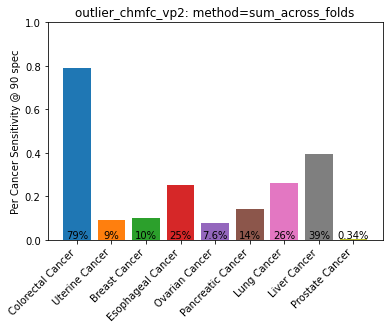

In [25]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_vp2"

loader = ExperimentLoader(bucket, path)
total_tp, total_tn, total_fp, total_fn = get_tp_tn_fp_fn_per_fold(loader)
plot_per_cancer_sens(total_tp, total_tn, total_fp, total_fn)

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: M

CRC Sens: 0.8
Other Cancer Sens: 0.176545842217484


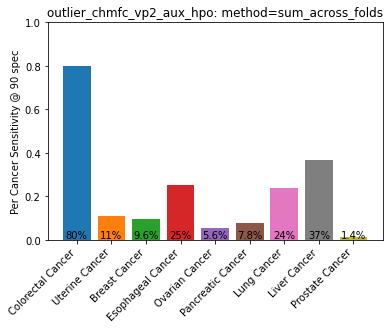

In [26]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_vp2_aux_hpo"

loader = ExperimentLoader(bucket, path)
total_tp, total_tn, total_fp, total_fn = get_tp_tn_fp_fn_per_fold(loader)
plot_per_cancer_sens(total_tp, total_tn, total_fp, total_fn)

In [ ]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/outlier_chmfc_MC_aux_hpo"

loader = ExperimentLoader(bucket, path)
total_tp, total_tn, total_fp, total_fn = get_tp_tn_fp_fn_per_fold(loader)
plot_per_cancer_sens(total_tp, total_tn, total_fp, total_fn)


# Model Score Plots

In [1]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
import os

#from featureio import FeatureIO 
#from calzone import Calzone

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
#from pineapple.contrib.components.transformers.methyl.poisson_outlier import ChooseSettingsAndRegionsForPoissonV2
#from pineapple.contrib.specs.transformer_specs import ChooseSettingsAndRegionsForPoissonSpecV2

#from pineapple.contrib.results.results_loader import load_results
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader, ExperimentLoader
import pineappleflow.core.experiment_context as experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 8, 19,0,0))

from collections import defaultdict, Counter
print("a")

STATISTICAL TESTS: The most common metric functions have been moved to Pineappleflow. Please import by 'from pineappleflow.core.statistics_utils'. Currently includes: SensAndSpecMetrics, get_sens_and_spec, specificity_threshold_interpolated, specificity_thresholds


a


In [68]:
HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS"]
CANCER_TYPES = ["Colorectal Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]
def generate_exp_table(bucket, path, chains=1, spec=90):
    loader = ExperimentLoader(bucket,path)
    
    dfs = []
    for fold_name in loader.fold_names():
        fold_loader = loader.fold(fold_name)
        test_sids = fold_loader.post_transformer_fold_holder.test.sample_ids
        test_calls = fold_loader.model_fold_result.test.predictions
        chain_scores = fold_loader.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        #print(chain_scores.shape)
        metas = fold_loader.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.sample_metadata
        stages = [m.raw_sample_metadata['lims_top_diagnosis']['stage'] for m in metas]
        df = pd.DataFrame.from_dict({"sample_id": test_sids, 
                                           "fold": [fold_name]*len(test_sids),
                                           "fold_call": test_calls,
                                           "stage": stages,
                                           "chain0_score": chain_scores[:,0]})
        if chains == 2:
            df["chain1_score"] = chain_scores[:,1]
        
        dfs.append(df)
                      
    df_calls = pd.concat(dfs, axis=0)
                   
    table_loader = ExperimentTableLoader.from_experiment_loader(loader)
    df_samples = table_loader.sample_score_per_fold_table()
                   
    assert len(df_samples) == len(df_calls), f"Number total fold test samples {len(df_calls)} doesn't match number output samples {len(df_samples)}"
    
    df_samples_wcalls = pd.merge(df_samples, df_calls, on=["sample_id", "fold"], how="outer")
    
    assert len(df_samples_wcalls) == len(df_samples), f"Merged table {len(df_samples_wcalls)}. Orig: {len(df_samples)}"
    
    #	sample_id	fold	y_true	y_score	status	stage	subtype	inference chain0_score_mean chain1_score_mean
    return df_samples_wcalls


def plot_multicancer_sensitivities(df_samples, method='fold_score_avg', spec=90, nested=False, chains=2):

    if method is "fold_score_avg":
        df_samples['score_mean'] = df_samples.groupby(['sample_id'])['y_score'].transform(lambda x: np.mean(x))
        df_samples['chain0_score_mean'] = df_samples.groupby(['sample_id'])['chain0_score'].transform(lambda x: np.mean(x))
        if chains == 2:
            df_samples['chain1_score_mean'] = df_samples.groupby(['sample_id'])['chain1_score'].transform(lambda x: np.mean(x))
        df_sample_avg = df_samples.drop_duplicates(subset=["sample_id"])
    
        healthies = [l in HEALTHY_TYPES for l in df_sample_avg["status"]]
        df_healthy = df_sample_avg[healthies]
        #final calls
        thresh = np.percentile(df_healthy["score_mean"].values, spec)
        df_sample_avg["call90"] = [1 if score>=thresh else 0 for score in df_sample_avg['score_mean']]
        #chain0 calls
        thresh = np.percentile(df_healthy["chain0_score_mean"].values, spec)
        df_sample_avg["chain0_call90"] = [1 if score>=thresh else 0 for score in df_sample_avg['chain0_score_mean']]
        #chain1 calls
        if chains == 2:
            thresh = np.percentile(df_healthy["chain1_score_mean"].values, spec)
            df_sample_avg["chain1_call90"] = [1 if score>=thresh else 0 for score in df_sample_avg['chain1_score_mean']]

        print(df_sample_avg.head())
#         if nested is True:
#             # use only healthy samples called false positive by first model to calc spec. threshold 
#             call_0_thresh = np.percentile(df_sample_avg[healthies]["chain0_score_mean"].values, spec)
#             call_0s = [1 if score >= call_0_thresh else 0 for score in df_sample_avg["chain0_score_mean"]]
#             healthies = [call_0==1 and healthy is True for call_0,healthy in zip(call_0s,healthies)]
#             df_healthy = df_sample_avg[healthies]
#             thresh = np.percentile(df_healthy["score_mean"].values, spec)
#             df_sample_avg["call90"] = [1 if score>=thresh else 0 for score in df_sample_avg['score_mean']]
        
        call_col = "call90"
    
    elif method is "maj_vote":
        def maj_vote(calls):
            if np.sum(calls) >= 0.5*len(calls):
                return 1
            else:
                return 0
                   
        df_samples['maj_vote_call'] = df_samples.groupby(['sample_id'])['fold_call'].transform(lambda x: maj_vote(x))
        df_sample_avg = df_samples.drop_duplicates(subset=["sample_id"])
        call_col = "maj_vote_call"
    
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    sum_tps = 0
    non_crcs = 0
    for i in np.unique(df_sample_avg['status']):
        if i in (HEALTHY_TYPES + skip):
            continue
        types.append(i)
        subset = [l in (HEALTHY_TYPES + [i]) for l in df_sample_avg["status"]]
        df = df_sample_avg[subset]
        n_tp = np.sum([(lab==i) and (call==1) for lab,call in zip(df["status"],df[call_col])])
        if i != "Colorectal Cancer":
            non_crcs += np.sum([s == i for s in df["status"]])
            sum_tps += n_tp
        call_rates.append(n_tp/np.sum([lab==i for lab in df["status"]]))
        
    fig, ax = plt.subplots()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.bar(types, call_rates, color=colors )
    plt.ylabel("Per Cancer Sensitivity @ 90 spec")
    plt.ylim([0,1])
    plt.title(f"{os.path.basename(path)}: method={method}")
    plt.xticks(types, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, call_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    crc_sens = call_rates[list(types).index("Colorectal Cancer")]
    print(f"CRC Sens: {crc_sens}")
    print(f"Other Cancer Sens: {sum_tps/float(non_crcs)}")
    
    return df_sample_avg


In [57]:
def plot_scores(df_sample_avg):
    
    def _log(scores):
        return np.log(scores + 1)
    
    # plot chain0 vs. combined scores
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,7))
    
    df_crc = df_sample_avg[df_sample_avg["y_true"]==1]
    ax[0].scatter(_log(df_crc["chain0_score_mean"]), _log(df_crc["score_mean"]), color="red", label="CRC")
    df_healthy = df_sample_avg[[t in HEALTHY_TYPES for t in df_sample_avg["status"]]]
    ax[1].scatter(_log(df_healthy["chain0_score_mean"]), _log(df_healthy["score_mean"]), color="blue", label="Healthy")
    df_mc = df_sample_avg[[t not in (HEALTHY_TYPES + ["Colorectal Cancer"]) for t in df_sample_avg["status"]]]
    ax[2].scatter(_log(df_mc["chain0_score_mean"]), _log(df_mc["score_mean"]), color="orange", label="Multicancer")
    
    print(min(df_healthy["chain0_score_mean"]))
    print(min(df_healthy["score_mean"]))
    
    model1_thresh = _log(np.percentile(df_healthy["chain0_score_mean"].values, 90))
    combined_thresh = _log(np.percentile(df_healthy["score_mean"].values, 90))
    for i in range(3):
        ax[i].set_title(os.path.basename(path))
        ax[i].set_xlabel("log(model1_score + 1)")
        ax[i].vlines(x=model1_thresh, ymin=min(_log(df_sample_avg["score_mean"]))-0.5,  
               ymax=max(_log(df_sample_avg["score_mean"])), linestyle="--", color="black")
        ax[i].set_ylabel("log(combined_score + 1)")
        ax[i].hlines(y=combined_thresh, xmin=min(_log(df_sample_avg["chain0_score_mean"]))-0.5,  
               xmax=max(_log(df_sample_avg["chain0_score_mean"])), linestyle="--", color="black")
        ax[i].legend()

In [62]:
def crc_sens_by_stage(path, df, method):
    '''
    input a sample by fold table or a sample averages table
    '''
    df_crc = df[df["y_true"]==1] # this should include CRC and AA
    sens = []
    labels = []
    sen_counts = []
#     stages = np.unique(df_crc["stage_x"])
    stages_str = ['AA','1','2','3','4']
#     if any([s not in stages_str for s in stages]):
#         print(f"WARNING: Unknown stage. Got {stages}")
    for stage in stages_str:
        if stage == 'AA':
            df_stage = df_crc[df_crc["status"]=="Colorectal Pre-Cancer"]
        else:
            df_stage = df_crc[df_crc["stage_x"]==stage]
        
        if len(df_stage) == 0:
            continue
        tps = list(df_stage["call90"].values).count(1)
        tot = float(len(df_stage))
        sen_final = tps / tot
        sen_counts.append((tps, tot))
        sen_chain0 = list(df_stage["chain0_call90"].values).count(1) / float(len(df_stage))
        sen_chain1 = list(df_stage["chain1_call90"].values).count(1) / float(len(df_stage))
        sens.append((sen_chain0, sen_chain1, sen_final))
        labels.append(f"CRC-{stage}\n(n={len(df_stage)})")
    
    tot_sen = np.sum([x[0] for x in sen_counts]) / float(np.sum([x[1] for x in sen_counts]))
    fig, ax = plt.subplots(figsize=(8,5))
    #width = 0.25
    x = np.array(range(len(labels)))
    #x2 = x + width
    #x3 = x2 + width
    #ax.bar(x, [s[0] for s in sens], width, color="orange", label="model 1")
    #ax.bar(x2, [s[1] for s in sens], width, color="green", label="model 2")
    #ax.bar(x3, [s[2] for s in sens], width, color="blue", label="combined")
    ax.bar(x, [s[2] for s in sens], color="blue", label="stage sens.")
    ax.bar(x[-1] + 1, tot_sen, color = "lightblue", label="total sens.")
    
    pos = list(range(len(labels) + 1))
    labs = list(labels) + ["Total"]
    plt.xticks(pos, labs)
    ax.set_ylabel("Sensitivity @90 spec.")
    #plt.xticks((x + width), labels)
    plt.ylim((0,1.0))
    plt.title(f"{os.path.basename(path)}, method:{method}")
   # add bar labels
    #sens = [ s for sublist in sens for s in sublist]
    for rect, sen in zip(ax.patches, [s[2] for s in sens] + [tot_sen]):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(sen*100):.0f}%", ha="center", va="bottom")
    plt.legend()

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0  0.000000   
1       5006  metadata_balanced_kfold_cancer_type_0       0  0.000000   
2      14879  metadata_balanced_kfold_cancer_type_0       0  1.009082   
3      20042  metadata_balanced_kfold_cancer_type_0       0  0.000000   
4      20050  metadata_balanced_kfold_cancer_type_0       0  0.000000   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          0     IIB   
1                Breast Cancer       2    None      False          0     IIB   
2  Colorectal Normal / Healthy    None    None      False          1    None   
3            Pancreatic Cancer       2    None      False          0     IIA   
4            Pancreatic Cancer       2    None      False          0     IIB   

   chain0_score  chain1_score  score_mean  chain0_score_mean  \
0     -0.000000 

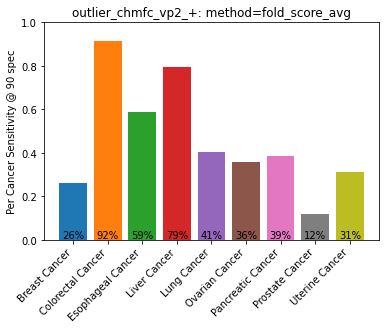

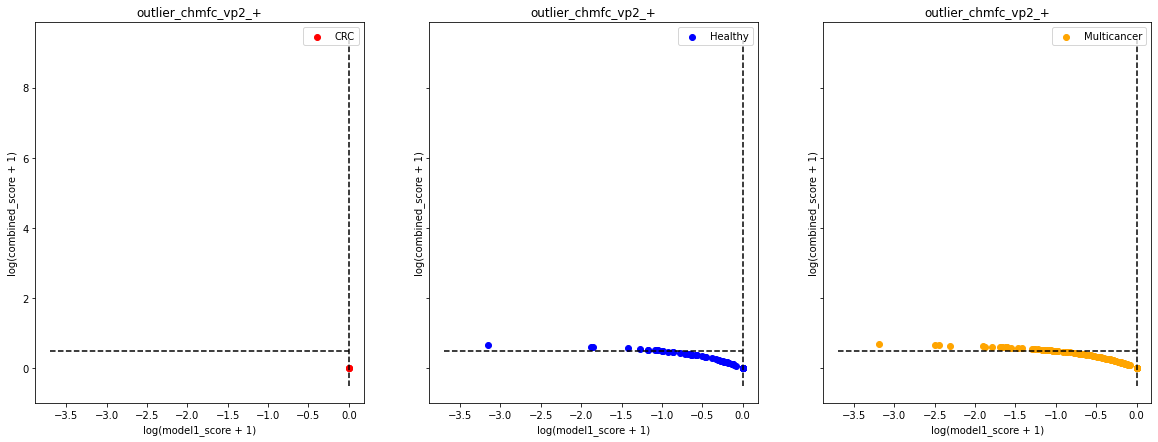

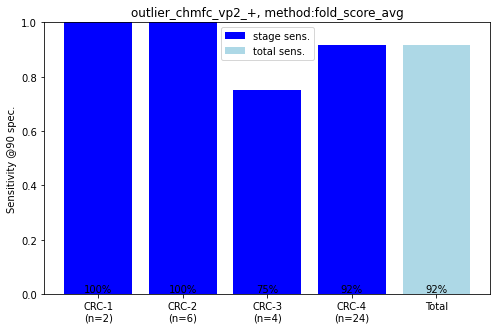

In [67]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/more_crcs/outlier_chmfc_vp2_+" 

df_samples = generate_exp_table(bucket, path, chains=2)
df_sample_avg = plot_multicancer_sensitivities(df_samples, method="fold_score_avg")
plot_scores(df_sample_avg)
crc_sens_by_stage(path, df_sample_avg, method="fold_score_avg")

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.238698   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.238698   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.238698   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.238698   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.238698   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          1     IIB   
1                Breast Cancer       2    None      False          1     IIB   
2  Colorectal Normal / Healthy    None    None      False          1    None   
3            Pancreatic Cancer       2    None      False          1     IIA   
4            Pancreatic Cancer       2    None      False          1     IIB   

   chain0_score  chain1_score  score_mean  chain0_score_mean  \
0     -0.095179 

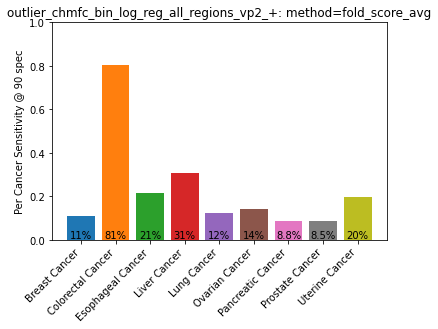

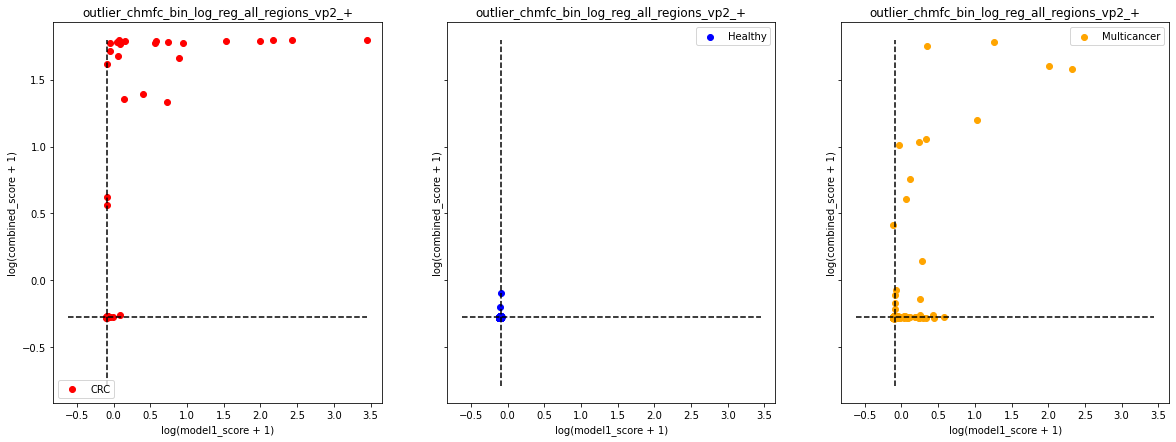

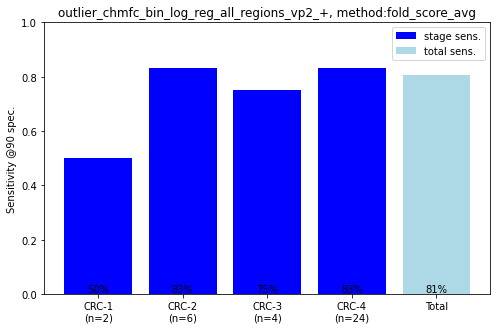

In [65]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/more_crcs/outlier_chmfc_bin_log_reg_all_regions_vp2_+" 

df_samples = generate_exp_table(bucket, path, chains=2)
df_sample_avg = plot_multicancer_sensitivities(df_samples, method="fold_score_avg")
plot_scores(df_sample_avg)
crc_sens_by_stage(path, df_sample_avg, method="fold_score_avg")

   sample_id                                   fold  y_true   y_score  \
0       4991  metadata_balanced_kfold_cancer_type_0       0 -0.455234   
1       5006  metadata_balanced_kfold_cancer_type_0       0 -0.455234   
2      14879  metadata_balanced_kfold_cancer_type_0       0 -0.455234   
3      20042  metadata_balanced_kfold_cancer_type_0       0 -0.455234   
4      20050  metadata_balanced_kfold_cancer_type_0       0 -0.455234   

                        status stage_x subtype  inference  fold_call stage_y  \
0                Breast Cancer       2    None      False          1     IIB   
1                Breast Cancer       2    None      False          1     IIB   
2  Colorectal Normal / Healthy    None    None      False          1    None   
3            Pancreatic Cancer       2    None      False          1     IIA   
4            Pancreatic Cancer       2    None      False          1     IIB   

   chain0_score  chain1_score  score_mean  chain0_score_mean  \
0     -0.095179 

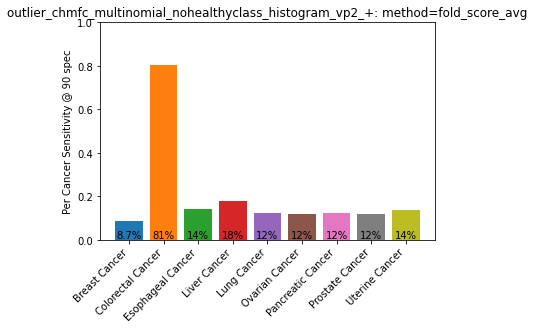

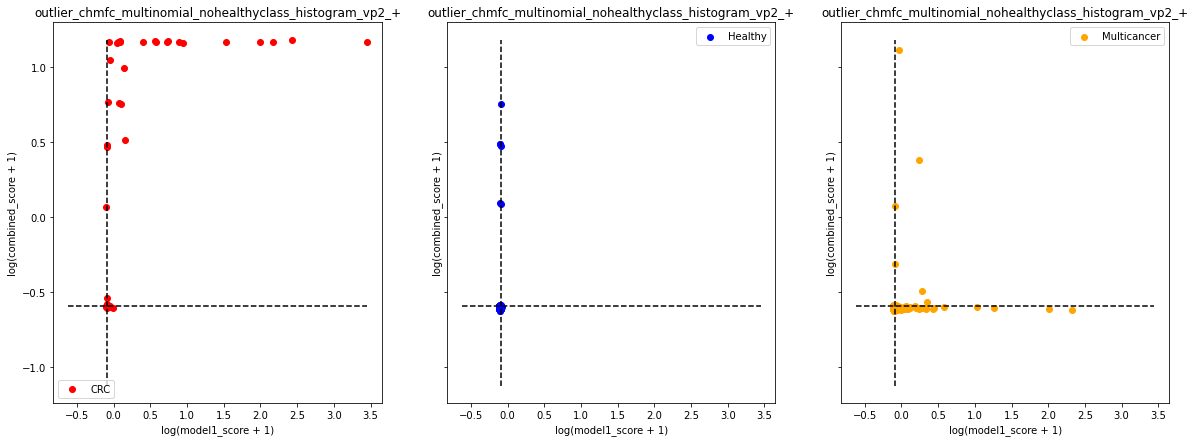

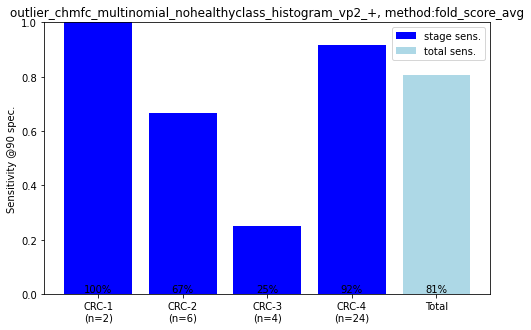

In [66]:
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/model_compare/more_crcs/outlier_chmfc_multinomial_nohealthyclass_histogram_vp2_+" 

df_samples = generate_exp_table(bucket, path, chains=2)
df_sample_avg = plot_multicancer_sensitivities(df_samples, method="fold_score_avg")
plot_scores(df_sample_avg)
crc_sens_by_stage(path, df_sample_avg, method="fold_score_avg")

In [ ]:
'''
so in the first plot here, there is one crc sample that is called healthy by the first model
and assigned the minimum Training crc score. For fold score averaging, the mean fold combined score
of the sample is lower than the mean of the mean fold healthy scores. In at least one of the folds,
the sample must have been called CRC by the first model!!
'''